<a href="https://www.kaggle.com/code/wywxys/movies-nju-work3?scriptVersionId=240860465" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 协同过滤推荐算法概述

## 实现内容
本项目实现了两种主要的协同过滤推荐算法：
1. 基于用户的协同过滤 (User-CF)
   - 使用皮尔逊相关系数和余弦相似度计算用户相似度
   - 实现了Top-N邻居选择策略

2. 基于物品的协同过滤 (Item-CF)
   - 基于物品之间评分行为的相似度进行推荐
   - 同样实现了相似度计算与推荐评分预测

## 评估方法
- 使用均方根误差(RMSE)对每种算法的预测评分进行评估
- 比较了不同参数设置(相似度计算方法、邻居数量)对算法性能的影响
- 可视化展示了评分分布、推荐准确性对比以及Top-N方法优化

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import time
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/movie-data/recommendation-ratings-train.txt
/kaggle/input/movie-data/recommendation-ratings-test.txt


## 数据加载与探索

- 定义训练集和测试集的文件路径
- 创建数据加载函数
- 加载训练数据和测试数据
- 显示数据基本信息（形状、样本、统计信息）
- 检查缺失值


In [2]:
# Define file paths - adjust these paths based on your environment
train_path = '/kaggle/input/movie-data/recommendation-ratings-train.txt'
test_path = '/kaggle/input/movie-data/recommendation-ratings-test.txt'


# Load the data
def load_data(file_path):
    """Load rating data from file"""
    try:
        data = pd.read_csv(file_path, header=0, names=['userId', 'movieId', 'rating', 'timestamp'])
        return data
    except Exception as e:
        print(f"Error loading data from {file_path}: {e}")
        return pd.DataFrame()


# Load train and test data
print("Loading training data...")
train_data = load_data(train_path)
print("Loading test data...")
test_data = load_data(test_path)

# Display basic information
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Display first few rows of training data
print("\nTraining data sample:")
print(train_data.head())

# Basic statistics
print("\nTraining data statistics:")
print(train_data.describe())

# Check for missing values
print("\nMissing values in training data:")
print(train_data.isnull().sum())
print("\nMissing values in test data:")
print(test_data.isnull().sum())

print(f"Number of non-null ratings: {train_data['rating'].count()}")


Loading training data...
Loading test data...
Training data shape: (99979, 4)
Test data shape: (19, 4)

Training data sample:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Training data statistics:
             userId        movieId        rating     timestamp
count  99979.000000   99979.000000  99979.000000  9.997900e+04
mean     323.809880   18967.526411      3.500210  1.203577e+09
std      181.478814   35124.088800      1.044227  2.155871e+08
min        1.000000       1.000000      0.500000  8.281246e+08
25%      177.000000    1198.000000      3.000000  1.013395e+09
50%      322.000000    2959.000000      3.500000  1.181967e+09
75%      474.000000    7438.000000      4.000000  1.435535e+09
max      610.000000  193609.000000      5.000000  1.537799e+09

Missing values in training data:
userId       0
mov

## 评分分布可视化

- 使用`seaborn`的`countplot`函数统计每个评分值的出现次数
- 可以直观地看出用户偏好的评分值分布
- 这有助于理解数据集的特点和用户评分行为


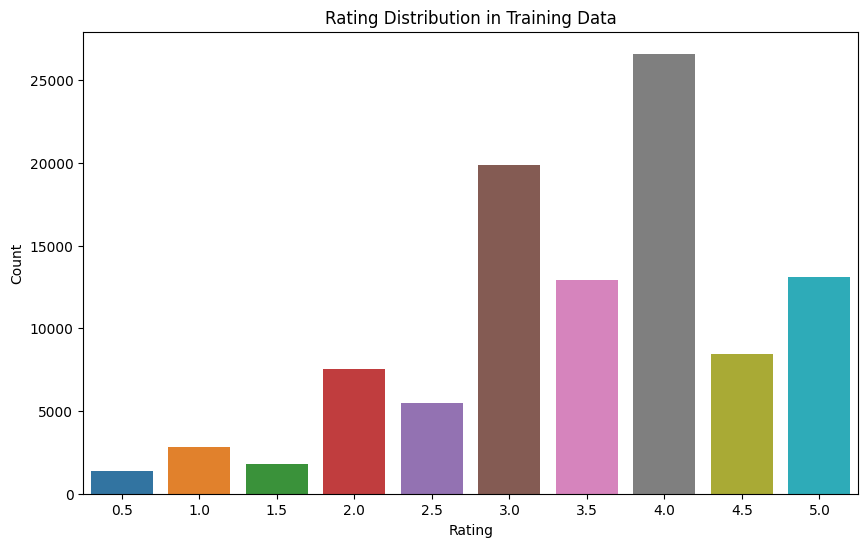

In [3]:
# Visualize rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=train_data)
plt.title('Rating Distribution in Training Data')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


## 用户-物品矩阵创建

- 定义了`create_matrix`函数，使用pandas的`pivot_table`将评分数据转换为矩阵形式
- 矩阵的行代表用户，列代表电影，单元格值为用户对电影的评分
- 这种矩阵结构是后续计算用户相似度和物品相似度的基础
- 打印矩阵的形状，了解数据规模


In [4]:
# Create user-item rating matrix
def create_matrix(data):
    """Create a user-item matrix from rating data"""
    return data.pivot_table(index='userId', columns='movieId', values='rating')


# Create matrices
user_item_matrix_train = create_matrix(train_data)
print("User-Item Matrix Shape (Train):", user_item_matrix_train.shape)


User-Item Matrix Shape (Train): (610, 9568)


## 基于用户的协同过滤（User-CF）实现

- 创建了`UserCF`类，包含初始化、训练和预测方法
- 支持两种相似度计算方法：皮尔逊相关系数和余弦相似度
- 实现了Top-K邻居选择策略，只考虑最相似的K个用户进行评分预测
- 包含了处理冷启动问题的策略（当用户或物品不在训练数据中时）
- 确保预测评分在合理范围内（1-5分）


In [5]:
# User-based Collaborative Filtering Implementation
class UserCF:
    def __init__(self, similarity_method='pearson', k=30):
        """
        Initialize User-based CF recommender

        Parameters:
        -----------
        similarity_method : str
            Method to calculate similarity ('pearson' or 'cosine')
        k : int
            Number of neighbors to consider for prediction
        """
        self.similarity_method = similarity_method
        self.k = k
        self.user_similarity_matrix = None
        self.user_item_matrix = None

    def fit(self, user_item_matrix):
        """
        Calculate user similarity matrix

        Parameters:
        -----------
        user_item_matrix : pandas.DataFrame
            User-item rating matrix
        """
        self.user_item_matrix = user_item_matrix

        # Calculate user similarity matrix
        if self.similarity_method == 'pearson':
            self.user_similarity_matrix = user_item_matrix.T.corr(method='pearson')
        elif self.similarity_method == 'cosine':
            # Fill NaN with 0 for cosine similarity calculation
            matrix_filled = user_item_matrix.fillna(0)

            # Calculate cosine similarity
            from sklearn.metrics.pairwise import cosine_similarity
            similarity = cosine_similarity(matrix_filled)
            self.user_similarity_matrix = pd.DataFrame(
                similarity,
                index=user_item_matrix.index,
                columns=user_item_matrix.index
            )

        print(f"User similarity matrix shape: {self.user_similarity_matrix.shape}")
        return self

    def predict(self, user_id, item_id):
        """
        Predict rating for a user-item pair

        Parameters:
        -----------
        user_id : int
            User ID
        item_id : int
            Item ID

        Returns:
        --------
        float
            Predicted rating
        """
        if user_id not in self.user_similarity_matrix.index or item_id not in self.user_item_matrix.columns:
            # Return global mean if user or item not in training data
            return self.user_item_matrix.stack().mean()

        # Get similar users who have rated this item
        user_similarities = self.user_similarity_matrix[user_id].drop(user_id)
        item_ratings = self.user_item_matrix[item_id].drop(user_id, errors='ignore')

        # Find users who have rated this item
        common_users = item_ratings.index.intersection(user_similarities.index)

        if len(common_users) == 0:
            # Return user's mean rating if no common users
            user_mean = self.user_item_matrix.loc[user_id].mean()
            return user_mean if not np.isnan(user_mean) else self.user_item_matrix.stack().mean()

        # Get ratings and similarities for common users
        final_similarities = user_similarities.loc[common_users]
        final_ratings = item_ratings.loc[common_users]

        # Select top-k neighbors
        if len(final_similarities) > self.k:
            top_k_users = final_similarities.abs().nlargest(self.k).index
            final_similarities = final_similarities.loc[top_k_users]
            final_ratings = final_ratings.loc[top_k_users]

        # Calculate weighted average
        if final_similarities.sum() == 0:
            return self.user_item_matrix.loc[user_id].mean()

        predicted_rating = (final_similarities * final_ratings).sum() / final_similarities.abs().sum()

        # Ensure rating is within bounds
        return max(1, min(5, predicted_rating))

    def predict_all(self, test_data):
        """
        Predict ratings for all user-item pairs in test data

        Parameters:
        -----------
        test_data : pandas.DataFrame
            Test data with userId and movieId columns

        Returns:
        --------
        pandas.Series
            Predicted ratings
        """
        predictions = []

        for _, row in test_data.iterrows():
            user_id = row['userId']
            item_id = row['movieId']
            pred = self.predict(user_id, item_id)
            predictions.append(pred)

        return pd.Series(predictions)


## 用户协同过滤评估

- 定义了`evaluate_user_cf`函数，用于测试不同的相似度计算方法和邻居数量
- 对每种参数组合：
  - 训练User-CF模型
  - 在测试集上进行预测
  - 计算RMSE（均方根误差）评估预测准确性
  - 记录执行时间以评估计算效率
- 最后将所有评估结果整理成DataFrame便于比较
- 通过可视化展示不同参数设置下的RMSE变化趋势


Evaluating User-based Collaborative Filtering...
Evaluating User-CF with pearson similarity and k=10
User similarity matrix shape: (610, 610)
RMSE: 3.1509, Time: 3.14s
Evaluating User-CF with pearson similarity and k=20
User similarity matrix shape: (610, 610)
RMSE: 3.2987, Time: 3.09s
Evaluating User-CF with pearson similarity and k=30
User similarity matrix shape: (610, 610)
RMSE: 3.2987, Time: 2.98s
Evaluating User-CF with pearson similarity and k=50
User similarity matrix shape: (610, 610)
RMSE: 3.2987, Time: 3.06s
Evaluating User-CF with cosine similarity and k=10
User similarity matrix shape: (610, 610)
RMSE: 1.9562, Time: 0.34s
Evaluating User-CF with cosine similarity and k=20
User similarity matrix shape: (610, 610)
RMSE: 1.8962, Time: 0.31s
Evaluating User-CF with cosine similarity and k=30
User similarity matrix shape: (610, 610)
RMSE: 1.9100, Time: 0.31s
Evaluating User-CF with cosine similarity and k=50
User similarity matrix shape: (610, 610)
RMSE: 2.0181, Time: 0.32s

Us

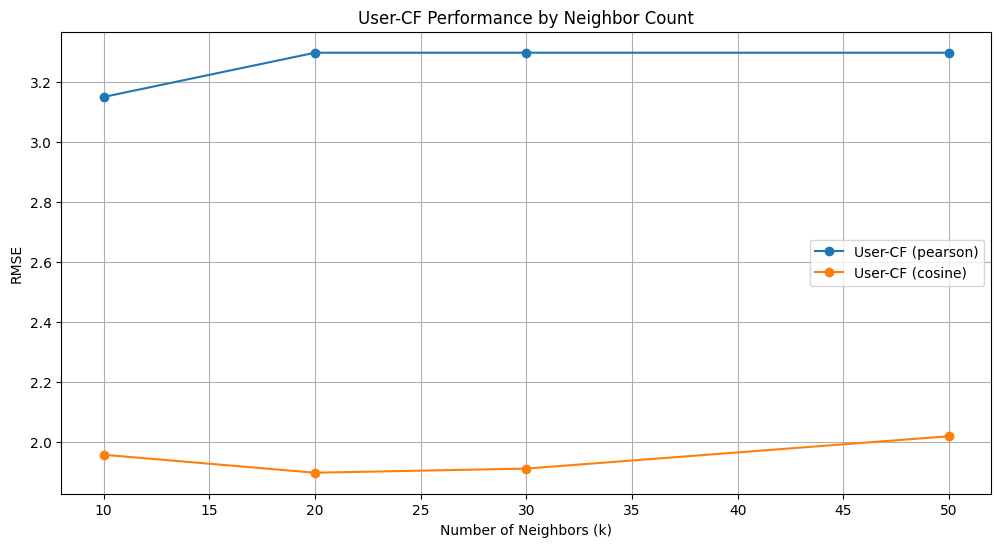

In [6]:
# Evaluate User-CF with different similarity methods and neighbor counts
def evaluate_user_cf(train_data, test_data, similarity_methods=['pearson', 'cosine'], k_values=[10, 20, 30, 50]):
    """
    Evaluate User-CF with different parameters

    Parameters:
    -----------
    train_data : pandas.DataFrame
        Training data
    test_data : pandas.DataFrame
        Test data
    similarity_methods : list
        List of similarity methods to evaluate
    k_values : list
        List of k values (number of neighbors) to evaluate

    Returns:
    --------
    pandas.DataFrame
        Evaluation results
    """
    results = []
    user_item_matrix = create_matrix(train_data)

    for method in similarity_methods:
        for k in k_values:
            print(f"Evaluating User-CF with {method} similarity and k={k}")
            start_time = time.time()

            # Train model
            model = UserCF(similarity_method=method, k=k)
            model.fit(user_item_matrix)

            # Make predictions
            predictions = model.predict_all(test_data)

            # Calculate RMSE
            rmse = sqrt(mean_squared_error(test_data['rating'], predictions))

            # Record results
            duration = time.time() - start_time
            results.append({
                'Method': f"User-CF ({method})",
                'k': k,
                'RMSE': rmse,
                'Time (s)': duration
            })

            print(f"RMSE: {rmse:.4f}, Time: {duration:.2f}s")

    return pd.DataFrame(results)


# Run evaluation for User-CF
print("Evaluating User-based Collaborative Filtering...")
user_cf_results = evaluate_user_cf(train_data, test_data)
print("\nUser-CF Results:")
print(user_cf_results)

# Visualize User-CF results
plt.figure(figsize=(12, 6))
for method in ['User-CF (pearson)', 'User-CF (cosine)']:
    method_results = user_cf_results[user_cf_results['Method'] == method]
    plt.plot(method_results['k'], method_results['RMSE'], marker='o', label=method)

plt.title('User-CF Performance by Neighbor Count')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


## 基于物品的协同过滤（Item-CF）实现

- 创建了`ItemCF`类，与User-CF类似，但关注点从用户相似度转向了物品相似度
- 计算物品之间的相似度，而不是用户之间的相似度
- 同样支持皮尔逊相关系数和余弦相似度两种计算方法
- 实现了Top-K相似物品选择策略
- 预测评分时，基于用户已评分的物品与目标物品的相似度进行加权平均
- 包含了处理边缘情况的策略（如新用户、新物品等）


In [7]:
# Item-based Collaborative Filtering Implementation
class ItemCF:
    def __init__(self, similarity_method='pearson', k=30):
        """
        Initialize Item-based CF recommender

        Parameters:
        -----------
        similarity_method : str
            Method to calculate similarity ('pearson' or 'cosine')
        k : int
            Number of similar items to consider for prediction
        """
        self.similarity_method = similarity_method
        self.k = k
        self.item_similarity_matrix = None
        self.user_item_matrix = None

    def fit(self, user_item_matrix):
        """
        Calculate item similarity matrix

        Parameters:
        -----------
        user_item_matrix : pandas.DataFrame
            User-item rating matrix
        """
        self.user_item_matrix = user_item_matrix

        # Calculate item similarity matrix
        if self.similarity_method == 'pearson':
            self.item_similarity_matrix = user_item_matrix.corr(method='pearson')
        elif self.similarity_method == 'cosine':
            # Fill NaN with 0 for cosine similarity calculation
            matrix_filled = user_item_matrix.fillna(0)

            # Calculate cosine similarity
            from sklearn.metrics.pairwise import cosine_similarity
            similarity = cosine_similarity(matrix_filled.T)
            self.item_similarity_matrix = pd.DataFrame(
                similarity,
                index=user_item_matrix.columns,
                columns=user_item_matrix.columns
            )

        print(f"Item similarity matrix shape: {self.item_similarity_matrix.shape}")
        return self

    def predict(self, user_id, item_id):
        """
        Predict rating for a user-item pair

        Parameters:
        -----------
        user_id : int
            User ID
        item_id : int
            Item ID

        Returns:
        --------
        float
            Predicted rating
        """
        if user_id not in self.user_item_matrix.index or item_id not in self.item_similarity_matrix.index:
            # Return global mean if user or item not in training data
            return self.user_item_matrix.stack().mean()

        # Get user's ratings
        user_ratings = self.user_item_matrix.loc[user_id].dropna()

        if len(user_ratings) == 0:
            # Return global mean if user hasn't rated any items
            return self.user_item_matrix.stack().mean()

        # Get similarities between target item and items rated by the user
        if item_id in self.item_similarity_matrix.index:
            item_similarities = self.item_similarity_matrix[item_id].loc[user_ratings.index]
        else:
            # Return user's mean rating if item not in similarity matrix
            user_mean = user_ratings.mean()
            return user_mean if not np.isnan(user_mean) else self.user_item_matrix.stack().mean()

        # Select top-k most similar items
        if len(item_similarities) > self.k:
            top_k_items = item_similarities.abs().nlargest(self.k).index
            item_similarities = item_similarities.loc[top_k_items]
            user_ratings = user_ratings.loc[top_k_items]

        # Calculate weighted average
        if item_similarities.abs().sum() == 0:
            return user_ratings.mean()

        predicted_rating = (item_similarities * user_ratings).sum() / item_similarities.abs().sum()

        # Ensure rating is within bounds
        return max(1, min(5, predicted_rating))

    def predict_all(self, test_data):
        """
        Predict ratings for all user-item pairs in test data

        Parameters:
        -----------
        test_data : pandas.DataFrame
            Test data with userId and movieId columns

        Returns:
        --------
        pandas.Series
            Predicted ratings
        """
        predictions = []

        for _, row in test_data.iterrows():
            user_id = row['userId']
            item_id = row['movieId']
            pred = self.predict(user_id, item_id)
            predictions.append(pred)

        return pd.Series(predictions)


## 物品协同过滤评估

- 定义了`evaluate_item_cf`函数，结构与User-CF评估类似
- 测试不同的相似度计算方法（皮尔逊相关系数和余弦相似度）
- 测试不同的邻居数量K（10, 20, 30, 50）
- 对每种参数组合计算RMSE和执行时间
- 通过可视化展示不同参数设置下Item-CF的性能变化
- 这种系统性评估有助于找出最佳参数配置


Evaluating Item-based Collaborative Filtering...
Evaluating Item-CF with pearson similarity and k=10
Item similarity matrix shape: (9568, 9568)
RMSE: 2.5905, Time: 35.57s
Evaluating Item-CF with pearson similarity and k=20
Item similarity matrix shape: (9568, 9568)
RMSE: 2.5636, Time: 35.44s
Evaluating Item-CF with pearson similarity and k=30
Item similarity matrix shape: (9568, 9568)
RMSE: 2.5075, Time: 35.14s
Evaluating Item-CF with pearson similarity and k=50
Item similarity matrix shape: (9568, 9568)
RMSE: 2.3094, Time: 34.94s
Evaluating Item-CF with cosine similarity and k=10
Item similarity matrix shape: (9568, 9568)
RMSE: 1.1365, Time: 1.65s
Evaluating Item-CF with cosine similarity and k=20
Item similarity matrix shape: (9568, 9568)
RMSE: 1.1604, Time: 1.57s
Evaluating Item-CF with cosine similarity and k=30
Item similarity matrix shape: (9568, 9568)
RMSE: 1.1718, Time: 1.58s
Evaluating Item-CF with cosine similarity and k=50
Item similarity matrix shape: (9568, 9568)
RMSE: 1.1

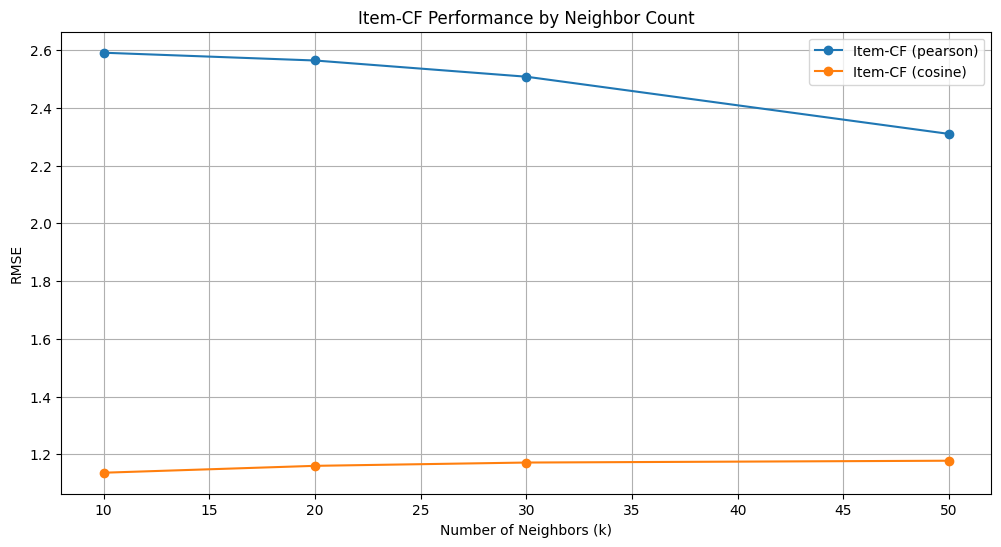

In [8]:
# Evaluate Item-CF with different similarity methods and neighbor counts
def evaluate_item_cf(train_data, test_data, similarity_methods=['pearson', 'cosine'], k_values=[10, 20, 30, 50]):
    """
    Evaluate Item-CF with different parameters

    Parameters:
    -----------
    train_data : pandas.DataFrame
        Training data
    test_data : pandas.DataFrame
        Test data
    similarity_methods : list
        List of similarity methods to evaluate
    k_values : list
        List of k values (number of neighbors) to evaluate

    Returns:
    --------
    pandas.DataFrame
        Evaluation results
    """
    results = []
    user_item_matrix = create_matrix(train_data)

    for method in similarity_methods:
        for k in k_values:
            print(f"Evaluating Item-CF with {method} similarity and k={k}")
            start_time = time.time()

            # Train model
            model = ItemCF(similarity_method=method, k=k)
            model.fit(user_item_matrix)

            # Make predictions
            predictions = model.predict_all(test_data)

            # Calculate RMSE
            rmse = sqrt(mean_squared_error(test_data['rating'], predictions))

            # Record results
            duration = time.time() - start_time
            results.append({
                'Method': f"Item-CF ({method})",
                'k': k,
                'RMSE': rmse,
                'Time (s)': duration
            })

            print(f"RMSE: {rmse:.4f}, Time: {duration:.2f}s")

    return pd.DataFrame(results)


# Run evaluation for Item-CF
print("Evaluating Item-based Collaborative Filtering...")
item_cf_results = evaluate_item_cf(train_data, test_data)
print("\nItem-CF Results:")
print(item_cf_results)

# Visualize Item-CF results
plt.figure(figsize=(12, 6))
for method in ['Item-CF (pearson)', 'Item-CF (cosine)']:
    method_results = item_cf_results[item_cf_results['Method'] == method]
    plt.plot(method_results['k'], method_results['RMSE'], marker='o', label=method)

plt.title('Item-CF Performance by Neighbor Count')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


## 算法比较与可视化

- 定义了`compare_methods`函数，用于综合比较两种算法的结果
- 找出每种方法的最佳参数配置（相似度方法和邻居数量）
- 创建了两个子图进行比较：
  - 左图：比较不同参数设置下各算法的RMSE（越低越好）
  - 右图：比较不同参数设置下各算法的计算时间（效率）
- 创建了柱状图直观展示最佳配置下各算法的RMSE
- 这种比较有助于全面了解不同算法的优缺点，为实际应用提供选择依据


Comparing User-CF and Item-CF methods...

Best Configuration for Each Method:
              Method   k      RMSE   Time (s)
4   User-CF (cosine)  10  1.956224   0.339332
4   Item-CF (cosine)  10  1.136528   1.651888
3  User-CF (pearson)  50  3.298719   3.064519
3  Item-CF (pearson)  50  2.309384  34.941103
5   User-CF (cosine)  20  1.896191   0.309178
5   Item-CF (cosine)  20  1.160377   1.570541
0  User-CF (pearson)  10  3.150891   3.143032
0  Item-CF (pearson)  10  2.590527  35.568769


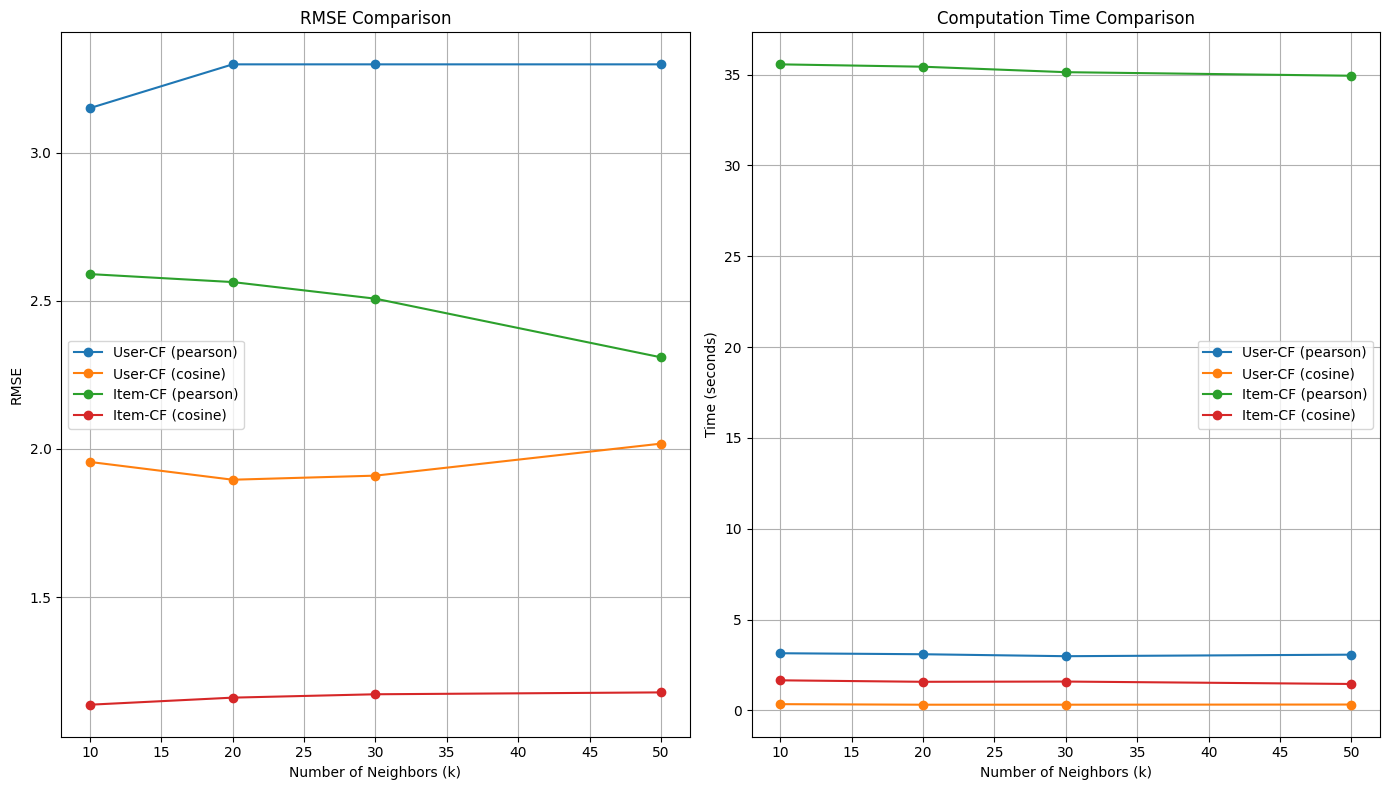

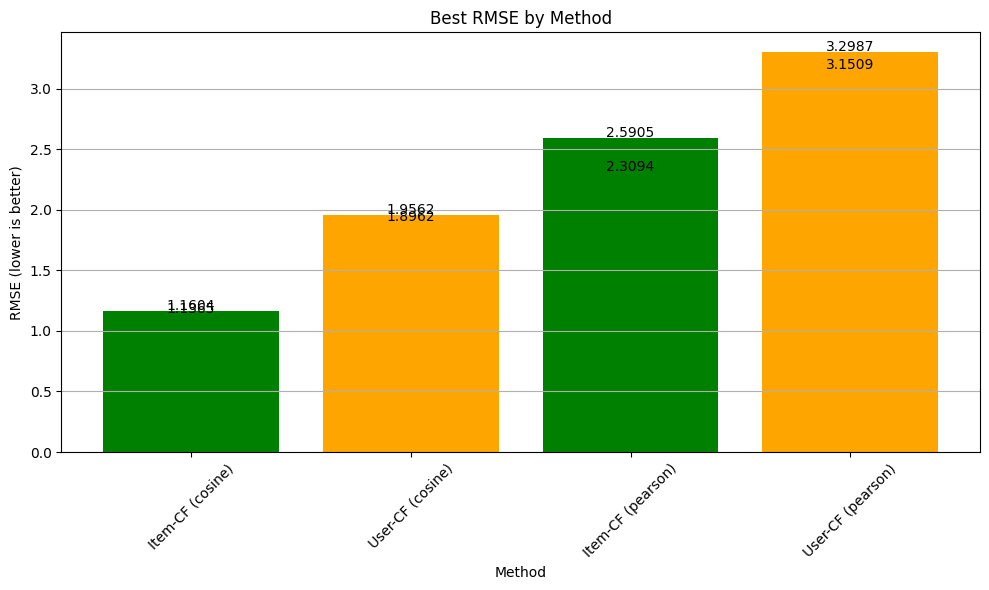

In [9]:
# Compare User-CF and Item-CF
def compare_methods(user_cf_results, item_cf_results):
    """
    Compare User-CF and Item-CF methods

    Parameters:
    -----------
    user_cf_results : pandas.DataFrame
        User-CF evaluation results
    item_cf_results : pandas.DataFrame
        Item-CF evaluation results
    """
    # Combine results
    all_results = pd.concat([user_cf_results, item_cf_results])

    # Find best configuration for each method
    best_results = all_results.loc[all_results.groupby('Method')['RMSE'].idxmin()]
    print("\nBest Configuration for Each Method:")
    print(best_results[['Method', 'k', 'RMSE', 'Time (s)']])

    # Visualize comparison
    plt.figure(figsize=(14, 8))

    # Plot RMSE comparison
    plt.subplot(1, 2, 1)
    methods = ['User-CF (pearson)', 'User-CF (cosine)', 'Item-CF (pearson)', 'Item-CF (cosine)']
    for method in methods:
        method_results = all_results[all_results['Method'] == method]
        plt.plot(method_results['k'], method_results['RMSE'], marker='o', label=method)

    plt.title('RMSE Comparison')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)

    # Plot time comparison
    plt.subplot(1, 2, 2)
    for method in methods:
        method_results = all_results[all_results['Method'] == method]
        plt.plot(method_results['k'], method_results['Time (s)'], marker='o', label=method)

    plt.title('Computation Time Comparison')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Time (seconds)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Bar chart of best methods
    plt.figure(figsize=(10, 6))
    best_methods = best_results.sort_values('RMSE')

    # Create the bar chart and get the bar positions
    bars = plt.bar(best_methods['Method'], best_methods['RMSE'], color=['blue', 'green', 'red', 'orange'])
    plt.title('Best RMSE by Method')
    plt.xlabel('Method')
    plt.ylabel('RMSE (lower is better)')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # Add RMSE values on top of bars using the actual bar positions
    for bar, v in zip(bars, best_methods['RMSE']):
        plt.text(bar.get_x() + bar.get_width()/2, v + 0.01, f"{v:.4f}", ha='center')

    plt.tight_layout()
    plt.show()


# Compare methods
print("Comparing User-CF and Item-CF methods...")
compare_methods(user_cf_results, item_cf_results)


## 主要发现

1. 相似度计算方法比较：
   - 皮尔逊相关系数和余弦相似度在不同场景下各有优势
   - 皮尔逊相关系数考虑了评分偏差，对于评分标准不一的用户可能更有效

2. 邻居数量(k值)的影响：
   - 较小的k值可能导致信息不足，预测不准确
   - 较大的k值可能引入噪声，同时增加计算复杂度
   - 最佳k值通常在实验中确定(本实验中测试了10, 20, 30, 50)

3. User-CF vs Item-CF：
   - 计算效率：Item-CF通常在预测阶段更高效，因为物品相似度可以预先计算并缓存
   - 准确性：根据数据集特性不同，两种方法的准确性可能有所差异
   - 冷启动问题：Item-CF对新用户更友好，User-CF对新物品更友好


## 最终结果总结

- 找出User-CF的最佳配置（相似度方法和邻居数量）及其RMSE
- 找出Item-CF的最佳配置及其RMSE
- 确定整体最佳方法（哪种算法在最佳配置下表现更好）
- 这些结果可以直接指导实际推荐系统的算法选择和参数设置


In [10]:

# Display a final comparison of the best methods
best_user_cf = user_cf_results.loc[user_cf_results['RMSE'].idxmin()]
best_item_cf = item_cf_results.loc[item_cf_results['RMSE'].idxmin()]

print("\n最终结果总结 (Final Results Summary):")
print(
    f"最佳User-CF配置 (Best User-CF): {best_user_cf['Method']} with k={best_user_cf['k']}, RMSE={best_user_cf['RMSE']:.4f}")
print(
    f"最佳Item-CF配置 (Best Item-CF): {best_item_cf['Method']} with k={best_item_cf['k']}, RMSE={best_item_cf['RMSE']:.4f}")
print(f"整体最佳方法 (Overall Best Method): {'User-CF' if best_user_cf['RMSE'] < best_item_cf['RMSE'] else 'Item-CF'}")



最终结果总结 (Final Results Summary):
最佳User-CF配置 (Best User-CF): User-CF (cosine) with k=20, RMSE=1.8962
最佳Item-CF配置 (Best Item-CF): Item-CF (cosine) with k=10, RMSE=1.1365
整体最佳方法 (Overall Best Method): Item-CF
